# Decision Trees on Amazon Fine Food Reviews dataset

## Importing necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import graphviz
from tqdm import tqdm

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

## Loading already prepared corpus

In [94]:
df = pd.read_csv("../input/corpus.csv")
df.head()

,Text,Time,Score
0,witti littl book make son laugh loud recit car...,939340800,1
1,grew read sendak book watch realli rosi movi i...,940809600,1
2,fun way children learn month year learn poem t...,944092800,1
3,great littl book read aloud nice rhythm well g...,944438400,1
4,book poetri month year goe month cute littl po...,946857600,1


## Taking out 100K datapoints to work on.

In [95]:
df1k = df.loc[:99999,:]
print("Shape of the data: ",df1k.shape)
print("Unique classes:- \n",df1k['Score'].value_counts())

Shape of the data:  (100000, 3)
Unique classes:- 
 1    87729
0    12271
Name: Score, dtype: int64


## Function for time based splitting into train and test data

In [96]:
from sklearn.model_selection import TimeSeriesSplit
def timesplit(x,y):
    ts = TimeSeriesSplit(n_splits = 4)
    for train_index,test_index in ts.split(x):
        x_train,x_test = x[train_index],x[test_index]
        y_train,y_test = y[train_index],y[test_index]
    return x_train,y_train,x_test,y_test

x_train,y_train,x_test,y_test = timesplit(df1k["Text"].values,df1k["Score"].values)

## BagofWords

In [84]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
bow_train = cv.fit_transform(x_train)
print("Shape of BOW vector:- ",bow_train.shape)

Shape of BOW vector:-  (80000, 34646)


### Parameter tuning using GridSearchCV

In [85]:
%%time
classifier = DecisionTreeClassifier(splitter='random',min_samples_leaf=0.01,class_weight='balanced',
                                    random_state=0)
param = {"max_depth":range(10,100,10)}
gs = GridSearchCV(classifier,param,scoring='f1_micro',cv=5,refit=False,n_jobs=-1)
gs.fit(bow_train,y_train)
print("Best estimator:- ",gs.best_params_)
print("Best score:- ",gs.best_score_)

Best estimator:-  {'max_depth': 20}
Best score:-  0.556575
CPU times: user 296 ms, sys: 212 ms, total: 508 ms
Wall time: 52.5 s


### Testing the model with the tuned parameters

In [86]:
classifier = DecisionTreeClassifier(splitter='random',max_depth=20,min_samples_leaf=0.01,
                                    class_weight='balanced',random_state=0)
classifier.fit(bow_train,y_train)
bow_test = cv.transform(x_test)
y_pred = classifier.predict(bow_test)
print("f1 score:- ",f1_score(y_test,y_pred))
print("Test accuracy score:- ",accuracy_score(y_test,y_pred))
print("Train accuracy score:- ",accuracy_score(y_train,classifier.predict(bow_train)))

f1 score:-  0.7930041924785682
Test accuracy score:-  0.6692
Train accuracy score:-  0.673675


### Confusion matrix of the model on original data(without oversampling)

Confusion Matrix:-
 [[  711  1964]
 [ 4652 12673]]


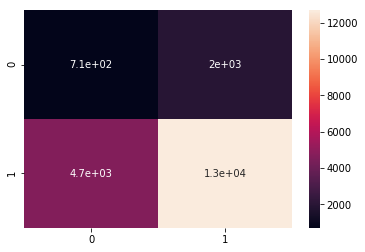

In [87]:
cm = confusion_matrix(y_test,y_pred)
print("Confusion Matrix:-\n",cm)
sns.heatmap(cm,annot=True)

### Decision Tree Graph

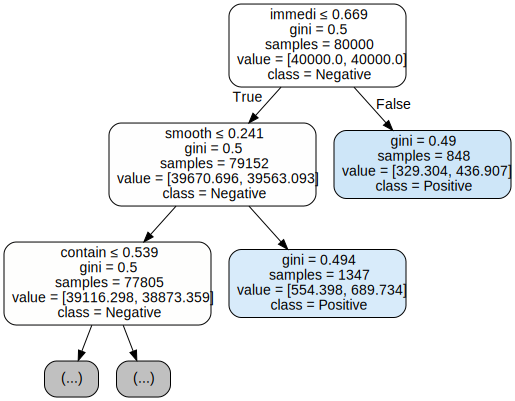

In [88]:
dot = graphviz.Source(tree.export_graphviz(classifier,out_file=None,max_depth=2,
                                feature_names=cv.get_feature_names(),filled=True,rounded=True,
                                class_names=['Negative','Positive'],
                                special_characters=True))
dot.format = 'png'
dot.render("bow_graph")
dot

### Feature Importance

In [89]:
ft = classifier.feature_importances_.argsort()
words = np.take(cv.get_feature_names(),ft)[::-1]
feat_imp = np.take(classifier.feature_importances_,ft)[::-1]
df_feat = pd.DataFrame()
df_feat['words'] = words
df_feat['Importance'] = feat_imp
print("Feature Importance:- \n",df_feat.head(20))

Feature Importance:- 
       words  Importance
0   conveni    0.099482
1      part    0.093178
2   contain    0.071719
3      leav    0.068249
4    awesom    0.060636
5    smooth    0.051566
6    immedi    0.051314
7   everyon    0.049762
8    result    0.049570
9      away    0.046084
10     less    0.045777
11     last    0.044060
12   origin    0.041923
13  definit    0.041407
14   reason    0.037641
15     care    0.033711
16    stock    0.030887
17  qualiti    0.030218
18     tell    0.027736
19    order    0.024038


### Oversampling to balance the class labels

In [90]:
%%time
print("Count of 1 before oversampling:- ",sum(y_train==1))
print("Count of 0 before oversampling:- ",sum(y_train==0))
sm = SMOTE(random_state = 0)
bow_train_ov,y_train_ov = sm.fit_sample(bow_train,y_train)
print("Count of 1 after oversampling:- ",sum(y_train_ov==1))
print("Count of 0 after oversampling:- ",sum(y_train_ov==0))
print("Shape of x_train data after oversampling:- ",bow_train_ov.shape)
print("Shape of y_train data after oversampling:- ",y_train_ov.shape)

Count of 1 before oversampling:-  70404
Count of 0 before oversampling:-  9596
Count of 1 after oversampling:-  70404
Count of 0 after oversampling:-  70404
Shape of x_train data after oversampling:-  (140808, 34646)
Shape of y_train data after oversampling:-  (140808,)
CPU times: user 40.4 s, sys: 1.77 s, total: 42.2 s
Wall time: 42.1 s


### Parameter tuning using GridSearchCV

In [91]:
%%time
classifier = DecisionTreeClassifier(splitter='random',min_samples_leaf=0.01,random_state=0)
param = {"max_depth":range(10,100,10)}
gs = GridSearchCV(classifier,param,scoring='f1',cv=5,refit=False,n_jobs=-1)
gs.fit(bow_train_ov,y_train_ov)
print("Best estimator:- ",gs.best_params_)
print("Best score:- ",gs.best_score_)

Best estimator:-  {'max_depth': 20}
Best score:-  0.7186390985884381
CPU times: user 316 ms, sys: 116 ms, total: 432 ms
Wall time: 42.6 s


### Testing the model with tuned parmaters

In [92]:
classifier = DecisionTreeClassifier(splitter='random',max_depth=20,min_samples_leaf=0.01,
                                    random_state=0)
classifier.fit(bow_train_ov,y_train_ov)
bow_test = cv.transform(x_test)
y_pred = classifier.predict(bow_test)
print("f1 score:- ",f1_score(y_test,y_pred))
print("Test accuracy score:- ",accuracy_score(y_test,y_pred))
print("Train accuracy score:- ",accuracy_score(y_train,classifier.predict(bow_train)))

f1 score:-  0.814223913110177
Test accuracy score:-  0.69725
Train accuracy score:-  0.696375


### Confusion Matrix of the oversampled data

Confusion Matrix:-
 [[  676  1999]
 [ 4056 13269]]


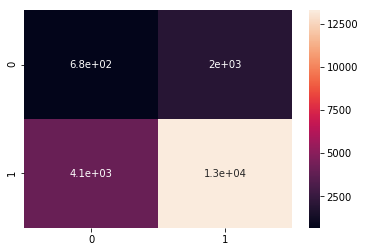

In [93]:
cm = confusion_matrix(y_test,y_pred)
print("Confusion Matrix:-\n",cm)
sns.heatmap(cm,annot=True)

#### Balancing the both class labels through oversampling has boosted the accuracy very little. 

### =====================================================================================

## Tfidf implementation

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True)
tfidf_train = tfidf.fit_transform(x_train)
print("Shape of tfidf_train:- ",tfidf_train.shape)

Shape of tfidf_train:-  (80000, 34646)


### Parameter tuning using GridSearchCV

In [52]:
%%time
classifier = DecisionTreeClassifier(splitter='random',min_samples_leaf=0.01,class_weight='balanced',
                                    random_state=0)
param = {"max_depth":range(10,60,5)}
gs = GridSearchCV(classifier,param,scoring='f1_micro',cv=5,refit=False,n_jobs=-1)
gs.fit(tfidf_train,y_train)
print("Best estimator:- ",gs.best_params_)
print("Best score:- ",gs.best_score_)

Best estimator:-  {'max_depth': 20}
Best score:-  0.6833375
CPU times: user 320 ms, sys: 72 ms, total: 392 ms
Wall time: 50.8 s


### Testing the model with the tuned parameters

In [53]:
classifier = DecisionTreeClassifier(splitter='random',max_depth=20,min_samples_leaf=0.01,
                                    class_weight='balanced',random_state=0)
classifier.fit(tfidf_train,y_train)
tfidf_test = tfidf.transform(x_test)
y_pred = classifier.predict(tfidf_test)
print("f1 score:- ",f1_score(y_test,y_pred))
print("Test accuracy score:- ",accuracy_score(y_test,y_pred))
print("Train accuracy score:- ",accuracy_score(y_train,classifier.predict(tfidf_train)))

f1 score:-  0.8370846730975349
Test accuracy score:-  0.7264
Train accuracy score:-  0.752675


### Confusion Matrix

Confusion Matrix:-
 [[  470  2205]
 [ 3267 14058]]


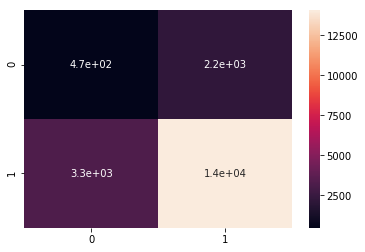

In [54]:
cm = confusion_matrix(y_test,y_pred)
print("Confusion Matrix:-\n",cm)
sns.heatmap(cm,annot=True)

### Decision Tree graph visualization

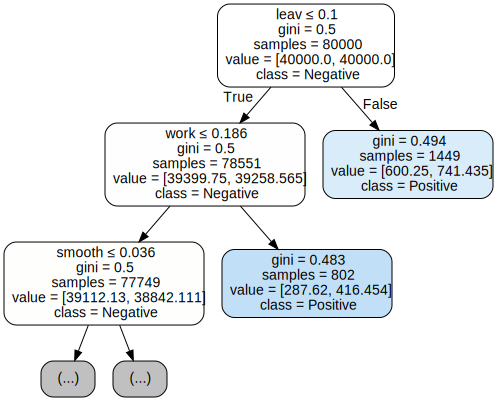

In [55]:
dot = graphviz.Source(tree.export_graphviz(classifier,out_file=None,max_depth=2,
                                feature_names=tfidf.get_feature_names(),filled=True,rounded=True,
                                class_names=['Negative','Positive'],
                                special_characters=True))
dot.format = 'png'
dot.render("tfidf_graph")
dot

### Feature Importance

In [56]:
ft = classifier.feature_importances_.argsort()
words = np.take(tfidf.get_feature_names(),ft)[::-1]
feat_imp = np.take(classifier.feature_importances_,ft)[::-1]
df_feat = pd.DataFrame()
df_feat['words'] = words
df_feat['Importance'] = feat_imp
print("Feature Importance:- \n",df_feat.head(20))

Feature Importance:- 
        words  Importance
0     delici    0.082415
1       bean    0.078826
2     result    0.074030
3    conveni    0.068269
4       work    0.066656
5    definit    0.058383
6    contain    0.053817
7       take    0.052037
8   sandwich    0.051115
9     expens    0.050673
10      care    0.050659
11    smooth    0.046337
12      glad    0.044688
13      leav    0.041522
14      milk    0.041491
15     never    0.040010
16   regular    0.033524
17       red    0.031112
18    reason    0.030642
19      like    0.003795


### =======================================================================================

## Word2Vec

In [57]:
#Function to create list of sentences
def sent_list(x):
    list_of_sent = []
    for sent in tqdm(x):
        words = []
        for w in sent.split():
            words.append(w)
        list_of_sent.append(words)
    return list_of_sent

In [58]:
#implementing word2vec
from gensim.models import Word2Vec
sent_train = sent_list(x_train)
w2v = Word2Vec(sent_train,size=50,min_count=2,workers=4)

100%|██████████| 80000/80000 [00:00<00:00, 93719.77it/s] 


## Average word2vec implementation

In [59]:
#Function to create avg word2vec vector
def avgw2v(x):
    avgw2v_vec = []
    for sent in tqdm(x):
        sent_vec = np.zeros(50)
        count = 0
        for word in sent:
            try:
                vec = w2v.wv[word]
                sent_vec+=vec
                count+=1
            except:
                pass
        sent_vec/=count
        avgw2v_vec.append(sent_vec)
    return avgw2v_vec

In [60]:
#Creating average word2vec training data
avgw2v_train = np.array(avgw2v(sent_train))
print("Shape of avg word2vec train data:- ",avgw2v_train.shape)

100%|██████████| 80000/80000 [00:11<00:00, 7187.71it/s]


Shape of avg word2vec train data:-  (80000, 50)


### Parameter tuning using GridSearchCV

In [67]:
%%time
classifier = DecisionTreeClassifier(splitter='random',min_samples_leaf=0.005,
                                    class_weight='balanced',random_state=0)
param = {"max_depth":range(10,100,10)}
gs = GridSearchCV(classifier,param,scoring='f1_micro',cv=5,refit=False,n_jobs=-1)
gs.fit(avgw2v_train,y_train)
print("Best estimator:- ",gs.best_params_)
print("Best score:- ",gs.best_score_)

Best estimator:-  {'max_depth': 20}
Best score:-  0.5176375
CPU times: user 264 ms, sys: 60 ms, total: 324 ms
Wall time: 10.9 s


### Testing the model with tuned parameters

In [68]:
classifier = DecisionTreeClassifier(splitter='random',max_depth=20,min_samples_leaf=0.005,
                                    class_weight='balanced',random_state=0)
classifier.fit(avgw2v_train,y_train)
sent_test = sent_list(x_test)
avgw2v_test = np.array(avgw2v(sent_test))
y_pred = classifier.predict(avgw2v_test)
print("f1 score:- ",f1_score(y_test,y_pred))
print("Test accuracy score:- ",accuracy_score(y_test,y_pred))
print("Train accuracy score:- ",accuracy_score(y_train,classifier.predict(avgw2v_train)))

100%|██████████| 20000/20000 [00:02<00:00, 7241.49it/s]


f1 score:-  0.65608238575413
Test accuracy score:-  0.5191
Train accuracy score:-  0.5475375


### Confusion Matrix

Confusion Matrix:-
 [[1208 1467]
 [8151 9174]]


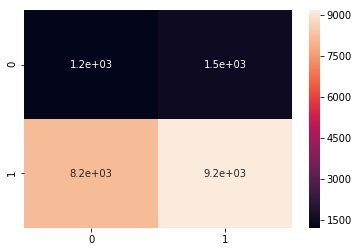

In [69]:
cm = confusion_matrix(y_test,y_pred)
print("Confusion Matrix:-\n",cm)
sns.heatmap(cm,annot=True)

### =======================================================================================

## Tfidf word2vec implementation

In [71]:
#Function for creating tfidf weighted Word2Vec
def tfidfw2v(x):
    dictionary = dict(zip(tfidf.get_feature_names(),list(tfidf.idf_)))
    tfidf_w2v_vec = []
    i=0
    for sent in tqdm(x):
        sent_vec = np.zeros(50)
        weights = 0
        for word in sent:
            try:
                vec = w2v.wv[word]
                tfidf_value = dictionary[word]*sent.count(word)
                sent_vec+=(tfidf_value*vec)
                weights+=tfidf_value
            except:
                pass
        sent_vec/=weights
        tfidf_w2v_vec.append(sent_vec)
        i+=1
    return tfidf_w2v_vec

In [72]:
tfidfw2v_train = np.array(tfidfw2v(sent_train))
print("Shape of tfidf avgw2v train vector:- ",tfidfw2v_train.shape)

100%|██████████| 80000/80000 [00:30<00:00, 2657.45it/s]


Shape of tfidf avgw2v train vector:-  (80000, 50)


### Parameter tuning using GridSearchCV

In [81]:
%%time
classifier = DecisionTreeClassifier(splitter='random',min_samples_leaf=0.001,class_weight='balanced',
                                    random_state=0)
param = {"max_depth":range(10,100,10)}
gs = GridSearchCV(classifier,param,scoring='f1_micro',cv=5,refit=False,n_jobs=-1)
gs.fit(tfidfw2v_train,y_train)
print("Best estimator:- ",gs.best_params_)
print("Best score:- ",gs.best_score_)

Best estimator:-  {'max_depth': 40}
Best score:-  0.5366
CPU times: user 244 ms, sys: 72 ms, total: 316 ms
Wall time: 13.2 s


### Testing the model with the tuned parameter

In [82]:
classifier = DecisionTreeClassifier(splitter='random',max_depth=40,min_samples_leaf=0.001,
                                    class_weight='balanced',random_state=0)
classifier.fit(tfidfw2v_train,y_train)
tfidfw2v_test = np.array(tfidfw2v(sent_test))
y_pred = classifier.predict(tfidfw2v_test)
print("f1 score:- ",f1_score(y_test,y_pred))
print("Test accuracy score:- ",accuracy_score(y_test,y_pred))
print("Train accuracy score:- ",accuracy_score(y_train,classifier.predict(tfidfw2v_train)))

100%|██████████| 20000/20000 [00:06<00:00, 2902.41it/s]


f1 score:-  0.6538489234535897
Test accuracy score:-  0.5193
Train accuracy score:-  0.5769375


### Confusion Matrix

Confusion Matrix:- 
 [[1306 1369]
 [8245 9080]]


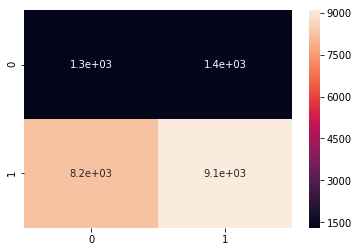

In [83]:
cm = confusion_matrix(y_test,y_pred)
print("Confusion Matrix:- \n",cm)
sns.heatmap(cm,annot = True)

### ======================================================================================

## Results:-

| Model | Hyperparameter(C) | Training Accuracy | Test Accuracy |
| - | - | - | - |
| Bag of Words | 20 | 67.2 | 66.9 |
|Tfidf | 20 | 75.2 | 72.6 |
| Avg Word2Vec | 20 | 54.7 | 51.9 |
| Tfidf Word2Vec | 40 | 57.6 | 51.93 |

## ====================================================================